<a href="https://colab.research.google.com/github/nika-va/practice/blob/main/04_transfer_learning_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_red = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_red.extractall()
zip_red.close()

In [ ]:
import os
for dir_path, dir_names, dir_files in os.walk('/content/10_food_classes_10_percent'):
  print(f' In {dir_path}, there are {len(dir_names)} directories, and {len(dir_files)} images')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

In [ ]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name +"/"+ experiment_name +'/'+ datetime.datetime.now().strftime('%Y%m%d')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'


def create_model(model_url, num_classes=10):
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name = 'feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])
  return model

In [ ]:
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [ ]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics='accuracy')

In [10]:
tensorboard = create_tensorboard_callback('tensorflow_hub','resnet_50v2' )
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=tensorboard)

Saving TensorBoard log files to: tensorflow_hub/resnet_50v2/20230926
Epoch 1/5
24/24 [==============================] - 25s 614ms/step - loss: 2.0336 - accuracy: 0.3293 - val_loss: 1.2146 - val_accuracy: 0.6164
Epoch 2/5
24/24 [==============================] - 13s 545ms/step - loss: 0.9327 - accuracy: 0.7360 - val_loss: 0.8992 - val_accuracy: 0.7024
Epoch 3/5
24/24 [==============================] - 11s 462ms/step - loss: 0.6434 - accuracy: 0.8213 - val_loss: 0.7625 - val_accuracy: 0.7508
Epoch 4/5
24/24 [==============================] - 11s 456ms/step - loss: 0.5027 - accuracy: 0.8680 - val_loss: 0.7122 - val_accuracy: 0.7616
Epoch 5/5
24/24 [==============================] - 11s 465ms/step - loss: 0.3881 - accuracy: 0.9093 - val_loss: 0.7007 - val_accuracy: 0.7676


<Axes: >

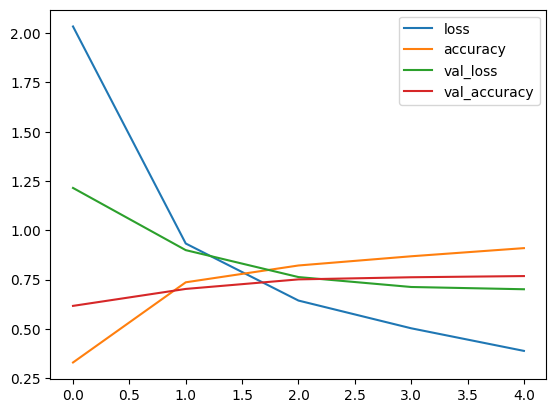

In [11]:
import pandas as pd
pd.DataFrame(resnet_history.history).plot()

In [12]:
import matplotlib.pyplot as plt

def plot_history_curves(model_history):
  """
  Plot model's history loss and the relavent metric curves seperately.
  """
  keys_names = list(model_history.history.keys())
  loss, metric, val_loss, val_metric = [model_history.history[key] for key in keys_names]
  epochs = range(len(model_history.history['loss']))

  plt.figure()
  plt.subplot(2,1,1)
  plt.plot(loss, label='loss')
  plt.plot(val_loss, label='val_loss')
  plt.title('Loss curves')
  plt.xticks(epochs)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2,1,2)
  plt.plot(metric, label=keys_names[1])
  plt.plot(val_metric, label=keys_names[3])
  plt.title(f'{keys_names[1].capitalize()} curves')
  plt.xticks(epochs)
  plt.xlabel('Epochs')
  plt.ylabel('Percentage')
  plt.legend()
  plt.tight_layout()

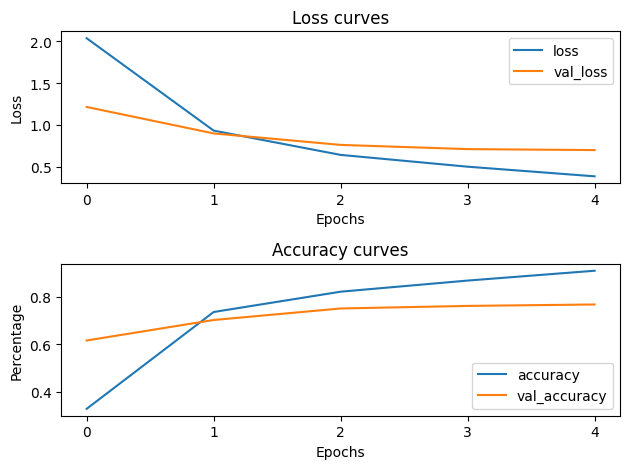

In [13]:
plot_history_curves(resnet_history)

In [14]:
efnet_model = create_model(model_url=efficientnet_url,
                           num_classes=train_data_10_percent.num_classes)
efnet_model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics='accuracy')
efnet_history = efnet_model.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data_10_percent,
                                validation_steps=len(test_data_10_percent),
                                callbacks=create_tensorboard_callback('tensorflow_hub','efnet_model' ))

Saving TensorBoard log files to: tensorflow_hub/efnet_model/20230926
Epoch 1/5
24/24 [==============================] - 22s 502ms/step - loss: 1.8015 - accuracy: 0.4680 - val_loss: 1.2782 - val_accuracy: 0.7492
Epoch 2/5
24/24 [==============================] - 10s 410ms/step - loss: 1.0372 - accuracy: 0.7893 - val_loss: 0.8549 - val_accuracy: 0.8288
Epoch 3/5
24/24 [==============================] - 9s 398ms/step - loss: 0.7419 - accuracy: 0.8347 - val_loss: 0.6899 - val_accuracy: 0.8448
Epoch 4/5
24/24 [==============================] - 10s 418ms/step - loss: 0.5968 - accuracy: 0.8707 - val_loss: 0.6067 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 9s 407ms/step - loss: 0.5073 - accuracy: 0.8827 - val_loss: 0.5572 - val_accuracy: 0.8616


In [ ]:
plot_history_curves(efnet_history)

In [ ]:
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
# --name "eff b0 vs resnet50v2" \
# --description "comparison of 2 models" \
# --one_shot

In [ ]:
# !tensorboard dev list

In [ ]:
# !tensorboard dev delete  --experiment_id Q1rOMWlLQ7Ws7fWsZZzE7g